## Regress out cell counts from all features on full dataset

In [2]:
import sys

sys.path.append("../scripts")

import numpy as np
import pandas as pd

from load import load_config
from preprocess import preprocess_profiles
from plot_utils import plot_unique_value_hist
from correct_position_effect import (
    subtract_well_mean,
    regress_out_cell_counts,
)

import seaborn as sns
from matplotlib import pyplot as plt

#### Load configs

In [43]:
cc_config = load_config("../configs/correction/regress_cell_count.yaml")
print(cc_config)
preprocess_config = load_config("../configs/preprocess")
print(preprocess_config)

{'cc_col': 'Cells_Count', 'min_unique': 100}
{'normalize_group': 'Metadata_Plate', 'normalize_kwargs': {'method': 'mad_robustize', 'mad_robustize_epsilon': 0.0, 'image_features': True}, 'feature_select_whitelist': ['Cells_Count'], 'feature_select_kwargs': {'operation': ['variance_threshold', 'correlation_threshold', 'drop_na_columns', 'blocklist'], 'unique_cut': 0.01, 'image_features': True}}


#### Load profiles

In [4]:
# ann_profiles = pd.read_parquet("../1.load/output/raw_filtered_profiles.parquet")
ann_profiles = pd.read_parquet('output/full_profiles_mean_corrected.parquet')
ann_profiles

,Metadata_JCP2022,Metadata_NCBI_Gene_ID,Metadata_Symbol,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_plate_map_name,Cells_Count,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_800001,NaN,no-guide,source_13,CP-CC9-R1-01,B02,platemap_0,62.459459,-10.182755,-20.890942,...,-3.862631,-3.664820,-3.736392,-3.673267,-3.737047,-3.764148,-3.862417,-3.781115,-3.857885,20220914_Run1
1,JCP2022_800001,NaN,no-guide,source_13,CP-CC9-R1-01,D23,platemap_0,-88.121622,13.511185,-26.582801,...,-2.301151,-2.193430,-2.229449,-2.200968,-2.223203,-2.238448,-2.272609,-2.244966,-2.275511,20220914_Run1
2,JCP2022_800001,NaN,no-guide,source_13,CP-CC9-R1-01,E02,platemap_0,-546.135135,259.093725,484.657662,...,-1.617813,-1.617517,-1.656778,-1.620639,-1.647435,-1.659770,-1.669550,-1.658336,-1.662867,20220914_Run1
3,JCP2022_800001,NaN,no-guide,source_13,CP-CC9-R1-01,G23,platemap_0,275.182432,-109.566202,-270.925378,...,-1.759293,-1.652236,-1.683296,-1.655596,-1.670177,-1.690362,-1.730114,-1.689546,-1.704179,20220914_Run1
4,JCP2022_800001,NaN,no-guide,source_13,CP-CC9-R1-01,H02,platemap_0,-90.290541,3.949089,-15.134490,...,-2.366627,-2.298069,-2.342259,-2.302632,-2.345338,-2.363542,-2.408907,-2.366728,-2.409337,20220914_Run1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51180,JCP2022_807640,7422.0,VEGFA,source_13,CP-CC9-R8-02,C15,platemap_148,-339.831081,195.601351,500.031325,...,8.298887,8.046988,8.039321,8.031805,8.042171,8.075438,8.104033,8.054266,8.116082,20221120_Run6
51181,JCP2022_807703,56949.0,XAB2,source_13,CP-CC9-R8-02,L19,platemap_148,-1537.155405,-368.010292,-649.740194,...,44.492747,44.581491,44.349367,44.561212,44.447041,44.365220,44.625260,44.360072,44.792690,20221120_Run6
51182,JCP2022_807717,7516.0,XRCC2,source_13,CP-CC9-R8-02,A12,platemap_148,-389.033784,-24.216678,109.138124,...,8.260589,7.975441,7.956049,8.018995,7.983360,7.933581,7.895637,7.956725,7.923038,20221120_Run6
51183,JCP2022_807725,64131.0,XYLT1,source_13,CP-CC9-R8-02,J18,platemap_148,471.621622,-265.240618,-398.765407,...,7.762943,7.290372,7.302278,7.306046,7.293134,7.331135,7.350168,7.321538,7.390558,20221120_Run6


In [5]:
ann_profiles.filter(regex="^(?!Metadata_)").isnull().any().any()

True

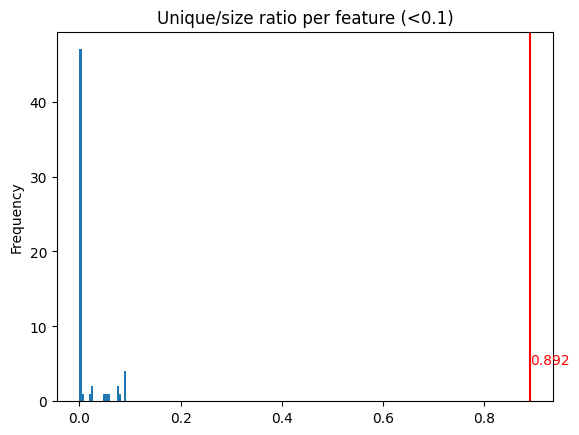

In [6]:
plot_unique_value_hist(ann_profiles, unique_ratio_cutoff=0.1, features="Cells_Count")

#### Explore correlations with cell counts

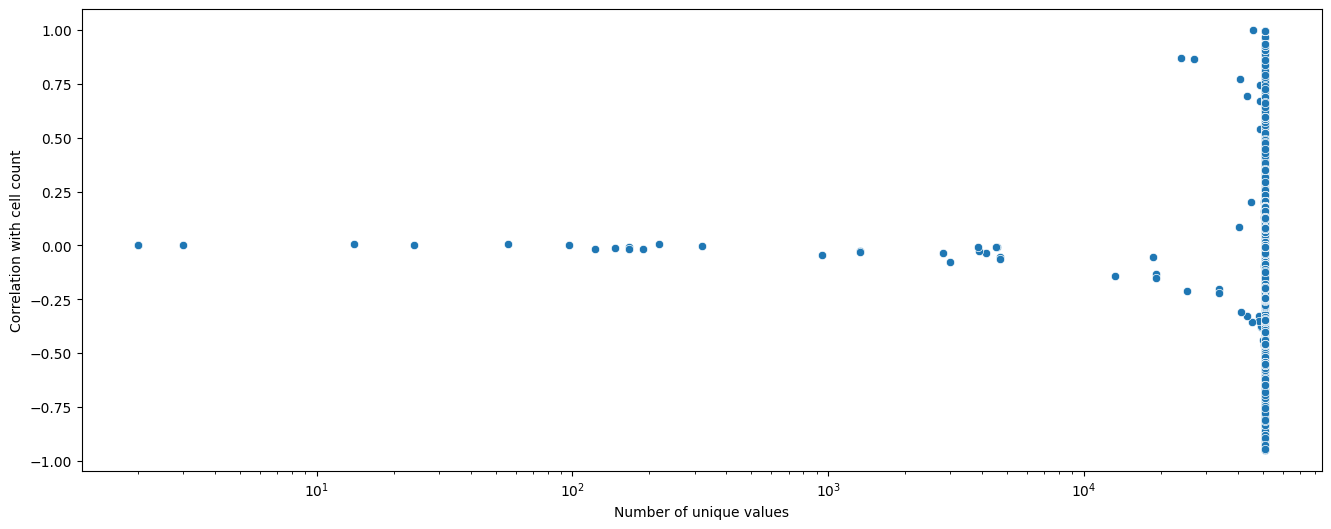

In [7]:
corr_cutoff = 0.4

plt.figure(figsize=(16, 6))
sns.scatterplot(
    data=ann_profiles.filter(regex="^(?!Metadata_)"),
    x=ann_profiles.filter(regex="^(?!Metadata_)").nunique(),
    y=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]),
    # hue=ann_profiles.filter(regex="^(?!Metadata_)")
    # .corrwith(ann_profiles["Cells_Count"])
    # .abs()
    # > corr_cutoff,
)
plt.xlabel("Number of unique values")
plt.ylabel("Correlation with cell count")

plt.xscale("log")

# plt.axhline(y=corr_cutoff, color="red", linestyle="--")
# plt.axhline(y=-corr_cutoff, color="red", linestyle="--")

plt.show()

#### List low unique ratio features that are correlated with cell count

No features that have nigh correlations and less than 1000 unique values

In [8]:
for feature in ann_profiles.filter(regex="^(?!Metadata_)").columns:
    feature_corr = ann_profiles["Cells_Count"].corr(ann_profiles[feature])
    if (feature_corr > corr_cutoff or feature_corr < -corr_cutoff) and ann_profiles[
        feature
    ].nunique() < 1000:
        print(f"{feature}: {ann_profiles.Cells_Count.corr(ann_profiles[feature])}")

#### Regress out cell counts only from features that have >100 unique values

In [9]:
ann_profiles = regress_out_cell_counts(ann_profiles, **cc_config)
ann_profiles

  0%|          | 0/4721 [00:00<?, ?it/s]

,Metadata_JCP2022,Metadata_NCBI_Gene_ID,Metadata_Symbol,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_plate_map_name,Cells_Count,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_800001,NaN,no-guide,source_13,CP-CC9-R1-01,B02,platemap_0,62.459459,18.460644,39.845742,...,-3.786948,-3.594622,-3.665255,-3.603145,-3.665912,-3.691984,-3.787335,-3.708989,-3.782823,20220914_Run1
1,JCP2022_800001,NaN,no-guide,source_13,CP-CC9-R1-01,D23,platemap_0,-88.121622,-26.900672,-112.273826,...,-2.407929,-2.292469,-2.329814,-2.299901,-2.323563,-2.340261,-2.378539,-2.346726,-2.381413,20220914_Run1
2,JCP2022_800001,NaN,no-guide,source_13,CP-CC9-R1-01,E02,platemap_0,-546.135135,8.640607,-46.413809,...,-2.279572,-2.231311,-2.278791,-2.233777,-2.269422,-2.290758,-2.326058,-2.288993,-2.319195,20220914_Run1
3,JCP2022_800001,NaN,no-guide,source_13,CP-CC9-R1-01,G23,platemap_0,275.182432,16.630217,-3.333111,...,-1.425851,-1.342962,-1.369881,-1.346653,-1.356775,-1.372424,-1.399318,-1.371775,-1.373474,20220914_Run1
4,JCP2022_800001,NaN,no-guide,source_13,CP-CC9-R1-01,H02,platemap_0,-90.290541,-37.457416,-102.934610,...,-2.476033,-2.399545,-2.445094,-2.404000,-2.448168,-2.467861,-2.517445,-2.470992,-2.517846,20220914_Run1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51180,JCP2022_807640,7422.0,VEGFA,source_13,CP-CC9-R8-02,C15,platemap_148,-339.831081,39.757590,169.573567,...,7.887110,7.665057,7.652276,7.650281,7.655142,7.682807,7.695523,7.661842,7.707684,20221120_Run6
51181,JCP2022_807703,56949.0,XAB2,source_13,CP-CC9-R8-02,L19,platemap_148,-1537.155405,-1072.937222,-2144.497315,...,42.630156,42.853905,42.598646,42.835471,42.696393,42.589238,42.777449,42.585022,42.945386,20221120_Run6
51182,JCP2022_807717,7516.0,XRCC2,source_13,CP-CC9-R8-02,A12,platemap_148,-389.033784,-202.624398,-269.165213,...,7.789192,7.538211,7.512965,7.582232,7.540294,7.484103,7.427980,7.507483,7.455510,20221120_Run6
51183,JCP2022_807725,64131.0,XYLT1,source_13,CP-CC9-R8-02,J18,platemap_148,471.621622,-48.958790,59.847805,...,8.334413,7.820420,7.839425,7.835528,7.830259,7.876032,7.917103,7.866149,7.957338,20221120_Run6


In [10]:
ann_profiles.to_parquet("output/profiles_cc_adjusted.parquet")

#### Check if cell count has correlation above 0.5 with any feature

In [11]:
for feature in ann_profiles.filter(regex="^(?!Metadata_)").columns:
    feature_corr = ann_profiles["Cells_Count"].corr(ann_profiles[feature])
    if np.abs(feature_corr) > 0.5:
        print(f"{feature}: {ann_profiles.Cells_Count.corr(ann_profiles[feature])}")

Cells_Count: 0.9999999999999998


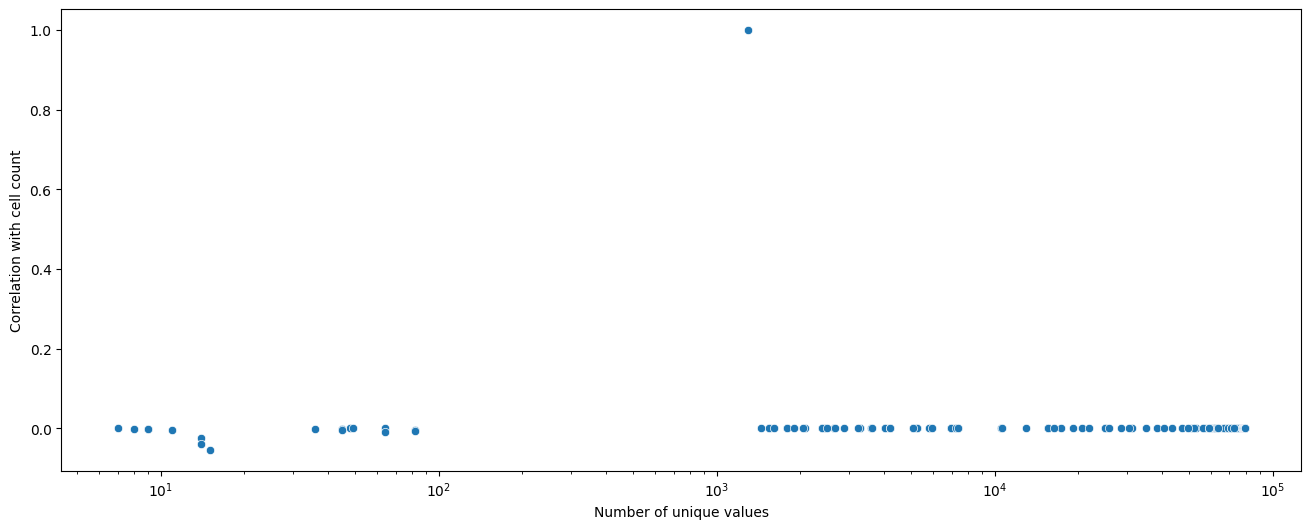

In [11]:
corr_cutoff = 0.4

plt.figure(figsize=(16, 6))
sns.scatterplot(
    data=ann_profiles.filter(regex="^(?!Metadata_)"),
    x=ann_profiles.filter(regex="^(?!Metadata_)").nunique(),
    y=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]),
    # hue=ann_profiles.filter(regex="^(?!Metadata_)")
    # .corrwith(ann_profiles["Cells_Count"])
    # .abs()
    # > corr_cutoff,
)
plt.xlabel("Number of unique values")
plt.ylabel("Correlation with cell count")

plt.xscale("log")


# plt.axhline(y=corr_cutoff, color="red", linestyle="--")
# plt.axhline(y=-corr_cutoff, color="red", linestyle="--")

plt.show()

#### Plot the ratio of unique values / size for cell count

This is one criteria to filter features in `feature_select`

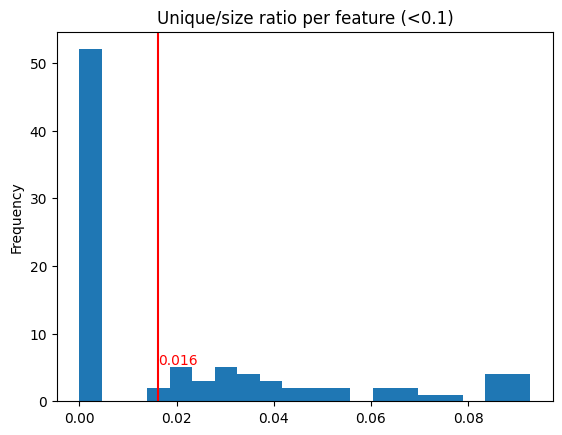

In [12]:
plot_unique_value_hist(ann_profiles, unique_ratio_cutoff=0.1, features="Cells_Count")

#### Preprocess and save CC-corrected subset

In [13]:
ann_profiles = pd.read_parquet("output/profiles_cc_adjusted.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,8.363270,6.547332,6.488146,6.165048,6.141906,6.595287,6.543043,6.072807,6.353294,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,21.560386,20.099374,20.601901,20.014168,20.448187,20.707467,21.672341,20.684496,21.471937,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,59.376581,56.186873,56.754792,55.838394,56.651311,57.334384,58.877185,56.876600,58.869780,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,11.859385,11.892405,12.274262,11.864552,12.286210,12.437484,13.167659,12.548097,13.198814,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,17.639769,17.253313,16.610972,16.580855,16.852392,17.103280,17.193383,16.573505,17.110850,2021_06_21_Batch7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.712837,-1.422843,-1.602391,-1.554015,-1.859480,-1.827975,-2.037851,-1.921880,-2.209741,2021_08_30_Batch13
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,4.984440,4.725925,4.687139,5.061615,4.853353,4.621572,4.649307,4.799437,4.707141,2021_08_30_Batch13
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,20.851246,19.679450,19.615606,19.936772,19.872247,19.497659,19.694786,20.039934,20.174176,2021_08_30_Batch13
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-22.885728,-21.654774,-22.053278,-21.601504,-21.885173,-22.275787,-23.031231,-22.256595,-22.997220,2021_08_30_Batch13


In [14]:
ann_profiles = preprocess_profiles(ann_profiles, **preprocess_config)
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_Mito_5_01_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_DNA_3_02_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256,Nuclei_Texture_InverseDifferenceMoment_DNA_10_01_256,Nuclei_Texture_InverseDifferenceMoment_Mito_10_01_256,Nuclei_Texture_SumVariance_AGP_5_01_256,Cells_Count
0,JCP2022_900257,ccsbBroad304_00280,ORF012864.1_TRC304.1,pLX_304,NM_001799.4,CDK7,1022,9606,cyclin dependent kinase 7,100.0,...,-1.231577,0.490227,0.062325,-0.435590,-0.229694,0.956789,0.753260,-0.012308,-1.296834,-1.152255
1,JCP2022_900258,ccsbBroad304_00281,ORF011987.1_TRC304.1,pLX_304,NM_001260.3,CDK8,1024,9606,cyclin dependent kinase 8,100.0,...,0.599487,-1.057567,-0.063772,0.000000,1.084028,-0.504171,-0.196982,-0.133785,0.537612,0.337245
2,JCP2022_900264,ccsbBroad304_00287,ORF008900.1_TRC304.1,pLX_304,NM_005193.1,CDX4,1046,9606,caudal type homeobox 4,100.0,...,0.482858,-0.077675,-0.832644,-0.890830,0.306157,-0.358296,-0.126532,-0.214288,-0.542846,-1.117125
3,JCP2022_900266,ccsbBroad304_00289,ORF011627.1_TRC304.1,pLX_304,NM_001805.3,CEBPE,1053,9606,CCAAT enhancer binding protein epsilon,100.0,...,0.828163,0.625896,-0.791639,-1.447235,-1.562389,-2.281529,2.627650,1.587568,0.823890,0.491816
4,JCP2022_900267,ccsbBroad304_00290,ORF016845.1_TRC304.1,pLX_304,NM_001252296.1,CEBPG,1054,9606,CCAAT enhancer binding protein gamma,100.0,...,-0.638493,-1.836099,1.026594,-0.993191,1.358627,0.130276,1.438015,0.316011,0.737111,0.126467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,1.136267,-1.204782,0.799465,-1.085394,0.890625,-1.481684,0.513214,1.077589,0.860113,-0.302011
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.081024,0.803678,1.048156,0.501873,-0.128035,-0.514228,0.016527,0.901899,-0.210535,-0.010067
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.337464,1.370658,-0.986768,-1.054934,-2.268375,0.697122,1.503346,-0.320936,-0.408083,-4.671100
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,0.556129,1.202156,-0.765855,0.031868,-0.676932,-0.072616,0.189121,1.006288,-1.585261,0.221475


In [15]:
# check that the cell count column is still there
assert cc_config["cc_col"] in ann_profiles.columns

ann_profiles.to_parquet("output/profiles_cc_adjusted_preprocessed.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_Mito_5_01_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_DNA_3_02_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256,Nuclei_Texture_InverseDifferenceMoment_DNA_10_01_256,Nuclei_Texture_InverseDifferenceMoment_Mito_10_01_256,Nuclei_Texture_SumVariance_AGP_5_01_256,Cells_Count
0,JCP2022_900257,ccsbBroad304_00280,ORF012864.1_TRC304.1,pLX_304,NM_001799.4,CDK7,1022,9606,cyclin dependent kinase 7,100.0,...,-1.231577,0.490227,0.062325,-0.435590,-0.229694,0.956789,0.753260,-0.012308,-1.296834,-1.152255
1,JCP2022_900258,ccsbBroad304_00281,ORF011987.1_TRC304.1,pLX_304,NM_001260.3,CDK8,1024,9606,cyclin dependent kinase 8,100.0,...,0.599487,-1.057567,-0.063772,0.000000,1.084028,-0.504171,-0.196982,-0.133785,0.537612,0.337245
2,JCP2022_900264,ccsbBroad304_00287,ORF008900.1_TRC304.1,pLX_304,NM_005193.1,CDX4,1046,9606,caudal type homeobox 4,100.0,...,0.482858,-0.077675,-0.832644,-0.890830,0.306157,-0.358296,-0.126532,-0.214288,-0.542846,-1.117125
3,JCP2022_900266,ccsbBroad304_00289,ORF011627.1_TRC304.1,pLX_304,NM_001805.3,CEBPE,1053,9606,CCAAT enhancer binding protein epsilon,100.0,...,0.828163,0.625896,-0.791639,-1.447235,-1.562389,-2.281529,2.627650,1.587568,0.823890,0.491816
4,JCP2022_900267,ccsbBroad304_00290,ORF016845.1_TRC304.1,pLX_304,NM_001252296.1,CEBPG,1054,9606,CCAAT enhancer binding protein gamma,100.0,...,-0.638493,-1.836099,1.026594,-0.993191,1.358627,0.130276,1.438015,0.316011,0.737111,0.126467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,1.136267,-1.204782,0.799465,-1.085394,0.890625,-1.481684,0.513214,1.077589,0.860113,-0.302011
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.081024,0.803678,1.048156,0.501873,-0.128035,-0.514228,0.016527,0.901899,-0.210535,-0.010067
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.337464,1.370658,-0.986768,-1.054934,-2.268375,0.697122,1.503346,-0.320936,-0.408083,-4.671100
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,0.556129,1.202156,-0.765855,0.031868,-0.676932,-0.072616,0.189121,1.006288,-1.585261,0.221475


#### Subtract well mean in cc adjusted profiles

In [16]:
ann_profiles = pd.read_parquet("output/profiles_cc_adjusted.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,8.363270,6.547332,6.488146,6.165048,6.141906,6.595287,6.543043,6.072807,6.353294,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,21.560386,20.099374,20.601901,20.014168,20.448187,20.707467,21.672341,20.684496,21.471937,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,59.376581,56.186873,56.754792,55.838394,56.651311,57.334384,58.877185,56.876600,58.869780,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,11.859385,11.892405,12.274262,11.864552,12.286210,12.437484,13.167659,12.548097,13.198814,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,17.639769,17.253313,16.610972,16.580855,16.852392,17.103280,17.193383,16.573505,17.110850,2021_06_21_Batch7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.712837,-1.422843,-1.602391,-1.554015,-1.859480,-1.827975,-2.037851,-1.921880,-2.209741,2021_08_30_Batch13
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,4.984440,4.725925,4.687139,5.061615,4.853353,4.621572,4.649307,4.799437,4.707141,2021_08_30_Batch13
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,20.851246,19.679450,19.615606,19.936772,19.872247,19.497659,19.694786,20.039934,20.174176,2021_08_30_Batch13
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-22.885728,-21.654774,-22.053278,-21.601504,-21.885173,-22.275787,-23.031231,-22.256595,-22.997220,2021_08_30_Batch13


In [17]:
ann_profiles = subtract_well_mean(ann_profiles)
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,18.094840,15.845488,15.896356,15.462843,15.557788,16.101178,16.327914,15.581127,16.141176,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,18.625084,17.249607,17.746422,17.180869,17.575946,17.811782,18.718973,17.821226,18.522294,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,29.496356,27.860144,28.085855,27.528428,27.988382,28.374475,29.023083,27.946044,29.048460,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,3.504982,3.955709,4.166485,3.911565,4.177823,4.240609,4.642764,4.321645,4.667072,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,35.112576,33.874398,33.433527,33.197952,33.690558,34.108267,34.717148,33.564914,34.645391,2021_06_21_Batch7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,10.534510,9.274802,9.232546,9.150787,8.995247,9.125396,9.274980,9.040851,9.111568,2021_08_30_Batch13
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,18.715211,17.831739,17.909115,18.154830,18.078674,17.963920,18.365409,18.113016,18.411996,2021_08_30_Batch13
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,12.357783,11.619484,11.388913,11.841221,11.629627,11.180517,11.088060,11.696845,11.538679,2021_08_30_Batch13
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,10.560400,10.124359,10.121988,10.167606,10.320124,10.230216,10.487286,10.242439,10.538297,2021_08_30_Batch13


In [18]:
ann_profiles.to_parquet("output/full_profiles_cc_adj_mean_corr.parquet", index=False)

In [19]:
ann_profiles = preprocess_profiles(ann_profiles, **preprocess_config)
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas2_DNA_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256,Nuclei_Texture_InfoMeas2_RNA_3_00_256,Nuclei_Texture_InverseDifferenceMoment_AGP_10_03_256,Nuclei_Texture_InverseDifferenceMoment_DNA_10_01_256,Nuclei_Texture_InverseDifferenceMoment_Mito_10_03_256,Nuclei_Texture_SumVariance_AGP_5_01_256,Nuclei_Texture_SumVariance_ER_10_01_256,Cells_Count
0,JCP2022_900257,ccsbBroad304_00280,ORF012864.1_TRC304.1,pLX_304,NM_001799.4,CDK7,1022,9606,cyclin dependent kinase 7,100.0,...,-0.086402,0.456224,0.700245,0.291046,-0.087758,0.506805,-0.308410,-1.256192,-0.997793,-0.619292
1,JCP2022_900258,ccsbBroad304_00281,ORF011987.1_TRC304.1,pLX_304,NM_001260.3,CDK8,1024,9606,cyclin dependent kinase 8,100.0,...,0.414273,0.555641,-0.655235,0.135209,-0.884628,-0.932580,-0.106488,0.490328,1.602166,0.936958
2,JCP2022_900264,ccsbBroad304_00287,ORF008900.1_TRC304.1,pLX_304,NM_005193.1,CDX4,1046,9606,caudal type homeobox 4,100.0,...,-0.779032,-0.386513,-0.557848,-0.326870,-0.160549,-0.411857,0.160352,-0.934831,-0.491796,-0.791061
3,JCP2022_900266,ccsbBroad304_00289,ORF011627.1_TRC304.1,pLX_304,NM_001805.3,CEBPE,1053,9606,CCAAT enhancer binding protein epsilon,100.0,...,-2.781218,-3.963993,-2.110178,-4.537758,1.688389,2.886424,1.474742,0.004469,-1.425807,-0.549618
4,JCP2022_900267,ccsbBroad304_00290,ORF016845.1_TRC304.1,pLX_304,NM_001252296.1,CEBPG,1054,9606,CCAAT enhancer binding protein gamma,100.0,...,-0.033917,-0.153706,-0.145185,-0.185935,0.756143,0.354097,0.697646,-0.666773,0.235939,0.023087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-0.789700,-0.359817,-0.780219,0.331250,0.147457,0.273237,1.005861,-0.434207,-0.867785,-0.974995
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,0.448500,0.865137,-0.757088,-0.585278,-0.640179,0.128282,0.765005,0.246946,-0.202649,0.693374
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-0.815270,-1.841199,0.309665,-2.522745,0.923912,1.412692,-0.042578,-0.073430,0.026199,-2.548669
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,0.421878,0.165000,-0.360294,-1.698831,0.714182,-0.214438,1.207206,-0.927648,-0.356581,1.121790


In [20]:
ann_profiles.to_parquet(
    "output/full_profiles_cc_adj_mean_corr_preprocessed.parquet", index=False
)

## Regress cell count from mean well subtracted profiles

In [44]:
ann_profiles = pd.read_parquet("output/full_profiles_mean_corrected.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,18.367661,16.105587,16.159180,15.722836,15.821556,16.366924,16.600643,15.846710,16.415157,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,17.906105,16.564178,17.053795,16.495712,16.880829,17.111443,18.000237,17.121315,17.800240,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,27.887779,26.326607,26.536201,25.995506,26.433174,26.807602,27.415031,26.380135,27.433006,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,-0.177261,0.445282,0.619171,0.402527,0.617767,0.653854,0.961739,0.737091,0.969116,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,35.570827,34.311272,33.874989,33.634655,34.133610,34.554638,35.175247,34.011013,35.105602,2021_06_21_Batch7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,8.449032,7.286636,7.223480,7.163403,6.978970,7.093994,7.190197,7.010700,7.017189,2021_08_30_Batch13
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,15.620144,14.881081,14.927452,15.205334,15.086300,14.949100,15.271366,15.100056,15.303703,2021_08_30_Batch13
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,6.947708,6.461838,6.177055,6.685608,6.399055,5.910713,5.679764,6.430290,6.105492,2021_08_30_Batch13
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,5.717976,5.507874,5.456985,5.552940,5.638371,5.513336,5.646461,5.528477,5.675186,2021_08_30_Batch13


In [50]:
cc_col = cc_config["cc_col"]
feature_cols = ann_profiles.filter(regex="^(?!Metadata_)").columns

corrs = [
    np.abs(ann_profiles[col].corr(ann_profiles[cc_col]))
    for col in feature_cols
    if col != cc_col
]
print(
    f"Number of features with correlation > 0.5 with {cc_col}: {np.sum(np.array(corrs) > 0.5)}"
)

Number of features with correlation > 0.5 with Cells_Count: 554


In [51]:
ann_profiles = regress_out_cell_counts(ann_profiles, **cc_config)
ann_profiles

  0%|          | 0/4722 [00:00<?, ?it/s]

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,18.014269,15.768495,15.818522,15.385891,15.479800,16.022515,16.246979,15.502497,16.060132,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,18.837414,17.452530,17.951544,17.383676,17.781473,18.019081,18.932261,18.028433,18.735853,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,29.971418,28.314137,28.544757,27.982168,28.448206,28.838282,29.500273,28.409651,29.526276,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,4.592426,4.994967,5.216984,4.950223,5.230406,5.302313,5.735096,5.382888,5.760852,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,34.977241,33.745064,33.302791,33.068695,33.559567,33.976138,34.581203,33.432844,34.509272,2021_06_21_Batch7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,11.150398,9.863401,9.827503,9.739041,9.591389,9.726701,9.893641,9.641899,9.731042,2021_08_30_Batch13
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,19.629263,18.705279,18.792104,19.027860,18.963414,18.856322,19.283570,19.005040,19.331355,2021_08_30_Batch13
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,13.955518,13.146412,12.932341,13.367259,13.176124,12.740409,12.692966,13.256075,13.145695,2021_08_30_Batch13
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,11.990491,11.491069,11.503473,11.533519,11.704355,11.626426,11.923803,11.638066,11.976696,2021_08_30_Batch13


In [53]:
corrs = [
    np.abs(ann_profiles[col].corr(ann_profiles[cc_col]))
    for col in feature_cols
    if col != cc_col
]
print(
    f"Number of features with correlation > 0.1 with {cc_col}: {np.sum(np.array(corrs) > 0.1)}"
)

Number of features with correlation > 0.1 with Cells_Count: 0


In [54]:
ann_profiles.to_parquet("output/full_profiles_mean_corr_cc_adj.parquet", index=False)